In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from joblib import dump, load

from nltk.tokenize import RegexpTokenizer
from sklearn.decomposition import TruncatedSVD
import xgboost as xgb

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

train['train_test'] = 'train'
test['train_test'] = 'test'

data = pd.concat([train, test])

/usr/lib/python3/dist-packages/ipykernel_launcher.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  import sys


In [3]:
data.head()

,country,description,designation,id,index,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,train_test,variety,winery
0,Portugal,This is a fine rich balanced wine. It has ripe...,Vila Santa Reserva,32027,NaN,88.870874,20.0,Alentejano,NaN,NaN,NaN,NaN,NaN,train,PORTUGUESE RED,J. Portugal Ramos
1,France,"A solid, chunky wine, with a structure that is...",NaN,71079,NaN,88.041695,28.0,Bordeaux,Lalande de Pomerol,NaN,NaN,NaN,NaN,train,BORDEAUX-STYLE RED BLEND,Château Tour Grand Colombier
2,France,"This is powerful and concentrated, with the hi...",NaN,32440,NaN,94.085021,130.0,Bordeaux,Saint-Émilion,NaN,NaN,NaN,NaN,train,BORDEAUX-STYLE RED BLEND,Château Figeac
3,US,"Rich, ripe and oaky, this Petite Sirah charms ...",Thompson Vineyard,124405,NaN,89.869797,34.0,California,Santa Barbara County,Central Coast,NaN,NaN,Jaffurs 2010 Thompson Vineyard Petite Sirah (S...,train,PETITE SIRAH,Jaffurs
4,US,This wine is a unique in the state blend and f...,McKinley Springs Vineyard,33649,NaN,89.017651,24.0,Washington,Horse Heaven Hills,Columbia Valley,Sean P. Sullivan,@wawinereport,Syncline 2016 McKinley Springs Vineyard Rosé (...,train,ROSé,Syncline


In [4]:
data.variety.fillna(value='PINOT NOIR', inplace=True)

In [5]:
data.province.fillna(value='California', inplace=True)

In [6]:
#data = data[pd.notnull(data['variety'])]
#data = data[pd.notnull(data['province'])]

In [7]:
data.taster_name.fillna(value='Roger Voss', inplace=True)

In [8]:
data.title.fillna(value='Gloria Ferrer NV Sonoma Brut Sparkling (Sonoma County)', inplace=True)


In [9]:
data['province'] = pd.Categorical(data['province'])
proDummies = pd.get_dummies(data['province'], prefix = 'prov')

data['country'] = pd.Categorical(data['country'])
countDummies = pd.get_dummies(data['country'], prefix = 'country')

data['variety'] = pd.Categorical(data['variety'])
varDummies = pd.get_dummies(data['variety'], prefix = 'variety')

data['taster_name'] = pd.Categorical(data['taster_name'])
tastDummies = pd.get_dummies(data['taster_name'], prefix = 'taster')

#data['title'] = pd.Categorical(data['title'])
#titleDummies = pd.get_dummies(data['title'], prefix = 'title')

In [10]:
def getQuality(points):
    if(points <= 85):
        return 'bad'
    elif(points<=90 ):
        return 'ok'
    elif(points<=95):
        return 'good'
    elif(points<=102):
        return 'great'
    else:
        return 'If this gets hit, we did something wrong!'

In [11]:
data['quality'] = data['points'].apply(getQuality)
cleanup_nums = {"quality":     {"ok": 2, "good": 3, "bad": 1, "great": 4},
                "priceRange": {"1-30": 1, "31-50": 2, "51-100": 3, "Above 100": 4}}

data.replace(cleanup_nums, inplace=True)

In [12]:
data.head(2)

,country,description,designation,id,index,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,train_test,variety,winery,quality
0,Portugal,This is a fine rich balanced wine. It has ripe...,Vila Santa Reserva,32027,NaN,88.870874,20.0,Alentejano,NaN,NaN,Roger Voss,NaN,Gloria Ferrer NV Sonoma Brut Sparkling (Sonoma...,train,PORTUGUESE RED,J. Portugal Ramos,2
1,France,"A solid, chunky wine, with a structure that is...",NaN,71079,NaN,88.041695,28.0,Bordeaux,Lalande de Pomerol,NaN,Roger Voss,NaN,Gloria Ferrer NV Sonoma Brut Sparkling (Sonoma...,train,BORDEAUX-STYLE RED BLEND,Château Tour Grand Colombier,2


In [13]:
def make_lower_case(text):
    return text.lower()

def remove_punctuation(text):
    tokenizer = RegexpTokenizer(r'\w+')
    text = tokenizer.tokenize(text)
    text = " ".join(text)
    return text

In [14]:
data["description"] = data["description"].str.replace('\d+', '')
data["description"] = data.description.apply(func=remove_punctuation)
data["description"] = data.description.apply(func=make_lower_case)

In [15]:
data["variety"] = data["variety"].str.replace('\d+', '')
data["variety"] = data.variety.apply(func=remove_punctuation)
data["variety"] = data.variety.apply(func=make_lower_case)

In [16]:
data["title"] = data["title"].str.replace('\d+', '')
data["title"] = data.title.apply(func=remove_punctuation)
data["title"] = data.title.apply(func=make_lower_case)

In [19]:
tf = TfidfVectorizer(analyzer='word', 
                     min_df=10,
                     ngram_range=(1, 2),
                     stop_words='english')
svd = TruncatedSVD(n_components=100)

In [20]:
#Fit tfidf and svd, and transform training data
tfidf_matrix = tf.fit_transform(data.description)
print(tfidf_matrix.shape)
desc_features = pd.DataFrame(svd.fit_transform(tfidf_matrix))
collist = map(str, range(0, 100))
collist = ["description_" + s for s in collist]
desc_features.columns = collist
desc_features.head()

(258210, 94009)


,description_0,description_1,description_2,description_3,description_4,description_5,description_6,description_7,description_8,description_9,...,description_90,description_91,description_92,description_93,description_94,description_95,description_96,description_97,description_98,description_99
0,0.115367,0.004635,0.114810,0.051503,0.006626,-0.030224,-0.025017,0.041989,0.028879,-0.010722,...,-0.001145,-0.005890,-0.020837,0.026162,0.047702,-0.002310,0.025185,0.016502,-0.014583,-0.023557
1,0.119707,0.024787,0.072113,0.021125,-0.011383,-0.062714,-0.000388,0.031308,0.015452,0.004678,...,0.008465,-0.006591,0.004663,-0.002114,-0.032946,0.005621,0.043270,-0.052529,0.021468,-0.014920
2,0.129262,0.101701,0.087819,0.003697,0.131599,-0.033489,-0.016941,0.006029,0.069171,-0.006437,...,0.014777,-0.021273,-0.004589,-0.017153,-0.042588,0.042764,0.027396,-0.018518,0.016041,0.032323
3,0.103500,0.062243,0.012432,-0.064512,-0.020306,-0.063626,-0.014884,-0.008086,0.045269,0.048528,...,-0.021261,-0.014641,0.049239,0.029474,-0.005462,0.062283,-0.034340,-0.033734,0.001570,-0.021269
4,0.096223,-0.056788,-0.015269,-0.012827,0.023453,0.028192,0.005492,0.016030,-0.026365,0.030248,...,0.008535,0.006225,-0.008858,0.009995,0.009698,-0.015669,-0.022837,0.025574,0.003234,0.006497


In [21]:
# tfidf_matrix = tf.fit_transform(data.variety)
# var_features = pd.DataFrame(svd.fit_transform(tfidf_matrix))
# collist = map(str, range(0, 10))
# collist = ["variety_" + s for s in collist]
# var_features.columns = collist
# var_features.head()

In [22]:
# prov_features = pd.DataFrame(svd.fit_transform(proDummies.values))
# collist = map(str, range(0, 10))
# collist = ["province_" + s for s in collist]
# prov_features.columns = collist
# prov_features.head()

In [24]:
#tfidf_matrix = tf.fit_transform(data.region_1)
#reg1_features = pd.DataFrame(svd.fit_transform(tfidf_matrix))
#collist = map(str, range(0, 10))
#collist = ["country_" + s for s in collist]
#reg1_features.columns = collist
#reg1_features.head()

In [23]:
# country_features = pd.DataFrame(svd.fit_transform(countDummies.values))
# collist = map(str, range(0, 10))
# collist = ["country_" + s for s in collist]
# country_features.columns = collist
# country_features.head()

In [24]:
# dd = pd.concat([desc_features, var_features, prov_features, country_features], axis=1)
dd = pd.concat([desc_features], axis=1)
dd.shape

(258210, 100)

In [25]:
#data.drop('index', axis=1, inplace=True)

In [26]:
dd['train_test'] = data.train_test.values

In [27]:
dd['id'] = data.id.values

In [28]:
dd['quality'] = data.quality.values

In [29]:
dd['points'] = data.points.values

In [30]:
dd['price'] = data.price.values

In [31]:
#['id', 'points', 'quality', 'price']
final_data = dd.copy()
final_data.shape

(258210, 105)

In [32]:
final_data['div_points'] = final_data['points'].values / 2
final_data['div_points_4'] = final_data['points'].values / 4
final_data['div_points_8'] = final_data['points'].values / 8

In [35]:
final_data['sum_desc'] = final_data[desc_features.columns.tolist()].sum(axis=1)
# final_data['sum_var'] = final_data[['variety_0', 'variety_1', 'variety_2',
#        'variety_3', 'variety_4', 'variety_5', 'variety_6', 'variety_7',
#        'variety_8', 'variety_9']].sum(axis=1)
# final_data['sum_prov'] = final_data[['province_0', 'province_1', 'province_2',
#        'province_3', 'province_4', 'province_5', 'province_6', 'province_7',
#        'province_8', 'province_9']].sum(axis=1)
# final_data['sum_country'] = final_data[['variety_0', 'variety_1', 'variety_2',
#        'variety_3', 'variety_4', 'variety_5', 'variety_6', 'variety_7',
#        'variety_8', 'variety_9']].sum(axis=1)

In [36]:
# final_data['description_0_x4'] = final_data['description_0'].multiply(4)
# final_data['description_0_x4'].head()

In [37]:
# final_data['description_1_x4'] = final_data['description_1'].multiply(4)
# final_data['description_1_x4'].head()

In [38]:
#final_data['div_points'].head(10)
final_data.head()

,description_0,description_1,description_2,description_3,description_4,description_5,description_6,description_7,description_8,description_9,...,description_99,train_test,id,quality,points,price,div_points,div_points_4,div_points_8,sum_desc
0,0.115367,0.004635,0.114810,0.051503,0.006626,-0.030224,-0.025017,0.041989,0.028879,-0.010722,...,-0.023557,train,32027,2,88.870874,20.0,44.435437,22.217719,11.108859,0.346464
1,0.119707,0.024787,0.072113,0.021125,-0.011383,-0.062714,-0.000388,0.031308,0.015452,0.004678,...,-0.014920,train,71079,2,88.041695,28.0,44.020848,22.010424,11.005212,0.039473
2,0.129262,0.101701,0.087819,0.003697,0.131599,-0.033489,-0.016941,0.006029,0.069171,-0.006437,...,0.032323,train,32440,3,94.085021,130.0,47.042511,23.521255,11.760628,0.403504
3,0.103500,0.062243,0.012432,-0.064512,-0.020306,-0.063626,-0.014884,-0.008086,0.045269,0.048528,...,-0.021269,train,124405,2,89.869797,34.0,44.934899,22.467449,11.233725,0.151633
4,0.096223,-0.056788,-0.015269,-0.012827,0.023453,0.028192,0.005492,0.016030,-0.026365,0.030248,...,0.006497,train,33649,2,89.017651,24.0,44.508825,22.254413,11.127206,-0.064729


In [82]:
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures

In [40]:
pf = PolynomialFeatures(degree=2, interaction_only=False,  
                        include_bias=False)
res = pf.fit_transform(final_data[['points', 'quality']])
res

array([[8.88708744e+01, 2.00000000e+00, 7.89803232e+03, 1.77741749e+02,
        4.00000000e+00],
       [8.80416953e+01, 2.00000000e+00, 7.75134011e+03, 1.76083391e+02,
        4.00000000e+00],
       [9.40850213e+01, 3.00000000e+00, 8.85199123e+03, 2.82255064e+02,
        9.00000000e+00],
       ...,
       [8.90575848e+01, 2.00000000e+00, 7.93125341e+03, 1.78115170e+02,
        4.00000000e+00],
       [8.49079088e+01, 1.00000000e+00, 7.20935297e+03, 8.49079088e+01,
        1.00000000e+00],
       [9.20387015e+01, 3.00000000e+00, 8.47112258e+03, 2.76116105e+02,
        9.00000000e+00]])

In [41]:
#pd.DataFrame(pf.powers_, columns=['points_degree',  'quality_degree'])

In [43]:
intr_features = pd.DataFrame(res, columns=['points', 'quality',  
                                           'points^2', 
                                           'points x quality',  
                                           'quality^2'])
intr_features.head(5)

,points,quality,points^2,points x quality,quality^2
0,88.870874,2.0,7898.032315,177.741749,4.0
1,88.041695,2.0,7751.340111,176.083391,4.0
2,94.085021,3.0,8851.991227,282.255064,9.0
3,89.869797,2.0,8076.580454,179.739594,4.0
4,89.017651,2.0,7924.142166,178.035302,4.0


In [44]:
intr_features['points_log'] = np.log((1 + intr_features['points']))
intr_features['points x quality_log'] = np.log((1 + intr_features['points x quality']))
intr_features['points^2_log'] = np.log((1 + intr_features['points^2']))

import scipy.stats as spstats

l, opt_lambda = spstats.boxcox(intr_features['points'].values)

intr_features['points_boxcox_lambda_opt'] = spstats.boxcox((1 + intr_features['points']), 
                                          lmbda=opt_lambda)
intr_features['points^2_boxcox_lambda_opt'] = spstats.boxcox((1 + intr_features['points^2']), 
                                          lmbda=opt_lambda)
intr_features['points x quality_boxcox_lambda_opt'] = spstats.boxcox((1 + intr_features['points x quality']), 
                                          lmbda=opt_lambda)

In [45]:
intr_features.head()

,points,quality,points^2,points x quality,quality^2,points_log,points x quality_log,points^2_log,points_boxcox_lambda_opt,points^2_boxcox_lambda_opt,points x quality_boxcox_lambda_opt
0,88.870874,2.0,7898.032315,177.741749,4.0,4.498374,5.185942,8.974496,5.046263,11.334832,5.922886
1,88.041695,2.0,7751.340111,176.083391,4.0,4.489105,5.176621,8.955750,5.034650,11.305444,5.910799
2,94.085021,3.0,8851.991227,282.255064,9.0,4.554771,5.646348,9.088511,5.117035,11.514180,6.527014
3,89.869797,2.0,8076.580454,179.739594,4.0,4.509428,5.197057,8.996848,5.060118,11.369912,5.937307
4,89.017651,2.0,7924.142166,178.035302,4.0,4.500006,5.187583,8.977796,5.048308,11.340009,5.925015


In [46]:
intr_features.drop(['points', 'quality'], inplace=True, axis=1)

In [47]:
ff = pd.concat([final_data, intr_features], axis=1)

In [48]:
print(ff.shape)

(258210, 118)


In [49]:
train_ff = ff[ff['train_test'] == 'train']
test_ff = ff[ff['train_test'] == 'test']

In [50]:
# c = ['points_log', 'points x quality_log', 'points_boxcox_lambda_opt','points^2_boxcox_lambda_opt', 'points x quality_boxcox_lambda_opt']

In [51]:
#col = ['description_0', 'description_1', 'description_2', 'description_3', 'description_4', 'description_5', 'description_6', 'description_7', 'description_8', 'description_9', 'sum_desc', 'description_0_x4', 'description_1_x4', 'points', 'points^2', 'points_log', 'points^2_log', 'points x quality_log', 'points_boxcox_lambda_opt','points^2_boxcox_lambda_opt', 'points x quality_boxcox_lambda_opt']
#col = ['description_0', 'description_1', 'description_2', 'description_3', 'description_4', 'description_5', 'description_6', 'description_7', 'description_8', 'description_9', 'variety_0', 'variety_1', 'variety_2', 'variety_3', 'variety_4', 'variety_5', 'variety_6', 'variety_7', 'variety_8', 'variety_9', 'province_0', 'province_1', 'province_2', 'province_3', 'province_4', 'province_5', 'province_6', 'province_7', 'province_8', 'province_9', 'country_0', 'country_1', 'country_2', 'country_3', 'country_4', 'country_5', 'country_6', 'country_7', 'country_8', 'country_9', 'sum_desc', 'sum_var', 'sum_prov', 'sum_country', 'description_0_x4', 'description_1_x4', 'points', 'points^2']

In [52]:
#print(intr_features.columns.tolist())
#cc = ['points^2', 'points x quality', 'points_log', 'points_boxcox_lambda_opt', 'points^2_boxcox_lambda_opt', 'points x quality_boxcox_lambda_opt']

In [53]:
#cc1 = ['points^2', 'points_log', 'points_boxcox_lambda_opt', 'points^2_boxcox_lambda_opt']

In [57]:
#print(train_ff.columns.tolist())

In [58]:
cols = desc_features.columns.tolist() + ['quality', 'points', 'div_points', 'div_points_4', 'div_points_8', 'sum_desc', 'points^2', 'points x quality', 'quality^2', 'points_log', 'points x quality_log', 'points^2_log', 'points_boxcox_lambda_opt', 'points^2_boxcox_lambda_opt', 'points x quality_boxcox_lambda_opt']

In [59]:
X = train_ff[cols]
y = train_ff["price"]

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [61]:
import lightgbm as lgb
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

In [62]:
lg = lgb.LGBMRegressor()
lg.fit(X_train,y_train)


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [63]:
lb_pred = lg.predict(X_test)

In [64]:
print('RMSE:', np.sqrt(mean_squared_error(y_test, lb_pred)))

RMSE: 26.56969456519251


In [65]:
model = xgb.XGBRegressor()

In [66]:
model.fit(X_train, y_train)

/home/aims/.local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:43:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [67]:
xgb_pred = model.predict(X_test)

In [68]:
print('RMSE:', np.sqrt(mean_squared_error(y_test, xgb_pred)))

RMSE: 27.863670651887002


In [86]:
#param = alphas=[1, 1e3, 1e6], store_cv_values=True
lm = RidgeCV()

lm.fit(X_train, y_train)

RidgeCV(alphas=array([ 0.1,  1. , 10. ]), cv=None, fit_intercept=True,
    gcv_mode=None, normalize=False, scoring=None, store_cv_values=False)

In [89]:
# cv_mse = np.mean(lm.cv_values_, axis=0)
# #print(alphas)
# print(cv_mse)
# print(np.sqrt(cv_mse))

In [90]:
print(lm.intercept_)

60.06789754498621


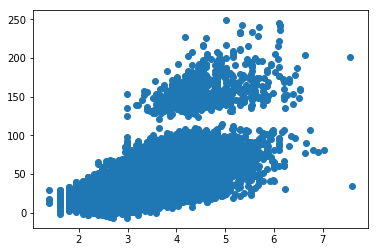

In [91]:
predictions = lm.predict(X_test)
plt.scatter(np.log(y_test),predictions)

In [92]:
print('RMSE:', np.sqrt(mean_squared_error(y_test, predictions)))

RMSE: 29.913484367330632


In [93]:
accuracy = lm.score(X_test, y_test)
print ("Accuracy is {}".format(accuracy))

Accuracy is 0.3192582055990373


In [110]:
rf = RandomForestRegressor()

In [111]:
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)

In [ ]:
rf.fit(X_train, y_train)

In [97]:
predicts = rf.predict(X_test)

In [98]:
print(y_test.shape, predicts.shape)

(52500,) (52500,)


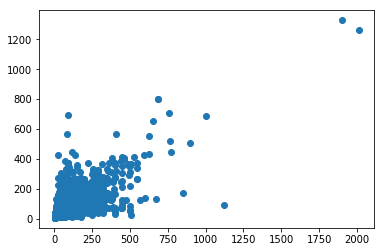

In [99]:
plt.scatter(y_test, predicts)

In [100]:
print('RMSE:', np.sqrt(mean_squared_error(y_test, predicts)))

RMSE: 22.871993990363805


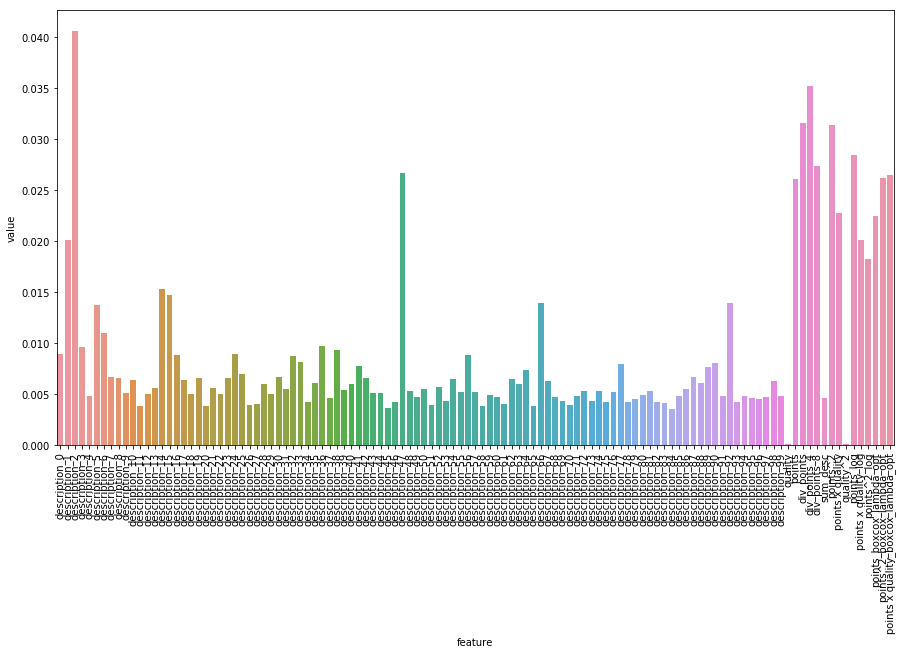

In [101]:
importance = pd.concat([pd.DataFrame(X_train.columns),pd.DataFrame(rf.feature_importances_)],axis=1)
importance.columns = ['feature','value']

plt.figure(figsize=(15,8))
sns.barplot(x="feature", y="value", data=importance).set_xticklabels(rotation=90,labels=X_train.columns)
print('')

In [ ]:
#print(test_data.columns.tolist())

In [102]:
X_test_t = test_ff[cols]

In [103]:
test_ff['price'] = rf.predict(X_test_t)
test_ff['price'].head(10)

/usr/lib/python3/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


175000    134.56
175001     47.18
175002     29.64
175003     24.79
175004     19.13
175005     21.32
175006     15.26
175007     18.84
175008     20.39
175009     46.05
Name: price, dtype: float64

In [104]:
test_ff['price_lm'] = lm.predict(X_test_t)
test_ff['price_lm'].head(10)

/usr/lib/python3/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


175000    155.721801
175001     41.437133
175002     32.485047
175003     28.200351
175004     20.455605
175005     19.857551
175006     10.726411
175007     20.006806
175008     35.762239
175009     40.618138
Name: price_lm, dtype: float64

In [105]:
test_ff['price_xgb'] = model.predict(X_test_t)
test_ff['price_xgb'].head(10)

/usr/lib/python3/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


175000    113.745300
175001     42.472370
175002     33.410439
175003     28.079285
175004     21.310186
175005     23.547581
175006     16.023575
175007     24.220209
175008     27.125593
175009     39.767555
Name: price_xgb, dtype: float32

In [106]:
test_ff['price_lg'] = lg.predict(X_test_t)
test_ff['price_lg'].head(10)

/usr/lib/python3/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


175000    160.733361
175001     43.356308
175002     34.366435
175003     26.903927
175004     22.673967
175005     19.669796
175006     16.910149
175007     23.753364
175008     27.633804
175009     41.667621
Name: price_lg, dtype: float64

In [ ]:
nnn

In [107]:
test_ff[['id', 'price']].to_csv('bma_predicted_rf_rmse22_87.csv', index=False)

In [ ]:
#pd.DataFrame(test_data_sss).to_csv('random_f.csv')

In [108]:
import pickle

In [109]:
pickle.dump(rf,open('rf_model_rmse22_87.sav','wb'))